# Transformer

## Import

In [3]:
import torch
from torchmetrics import Accuracy
from torch.utils.data import DataLoader , random_split , TensorDataset
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms as T

import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import glob

## Device

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

cuda


## Load Data

In [ ]:
num_class = 6

In [5]:
def har_dataset(phase):
  x = []
  data_dir = f'content/UCI HAR Dataset/{phase}/Inertial Signals/*'
  for file_dir in glob.glob(data_dir):
    x.append(np.loadtxt(file_dir))
  y = np.loadtxt(f'content/UCI HAR Dataset/{phase}/y_{phase}.txt')
  #
  x = torch.FloatTensor(x).permute(1, 2, 0)
  y = torch.LongTensor(y) - 1
  return x, y

In [6]:
x_train, y_train = har_dataset('train')
x_test, y_test = har_dataset('test')

C:\Users\BEHRAD\AppData\Local\Temp\ipykernel_23456\965338797.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  x = torch.FloatTensor(x).permute(1, 2, 0)


In [ ]:
x_train.shape, y_train.shape

(torch.Size([7352, 128, 9]), torch.Size([7352]))

In [ ]:
torch.unique(y_test)

tensor([0, 1, 2, 3, 4, 5])

In [ ]:
train_set = TensorDataset(x_train, y_train)
test_set = TensorDataset(x_test, y_test)

In [ ]:
torch.unique(y_test)

tensor([0, 1, 2, 3, 4, 5])

In [ ]:
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

In [ ]:
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)

torch.Size([256, 128, 9])
torch.Size([256])


## Transformer Model (Transformer Encoder)

In [ ]:
class EncoderTransformer(nn.Module) :

    def __init__(self , d_model , nhead , num_encoders , d_feed , dropout , activation) :
        super().__init__()
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d_model , nhead=nhead , dim_feedforward=d_feed , dropout=dropout , activation=activation ) , num_layers=num_encoders)
        self.fc = nn.LazyLinear(num_class)
        self.bn0 = nn.BatchNorm1d(d_model)
        self.l0 = nn.LazyLinear(d_model)

    def forward(self , x):
        x =  self.bn0(self.l0(x)).relu()
        y = self.encoder(x)
        y = self.fc(y.mean(dim=1))

        return y


In [ ]:
model = EncoderTransformer(128, 8, 8, 256, 0.1, 'relu')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
model(x).shape

torch.Size([256, 6])

In [ ]:
def num_params(model, k=1e6):
  nums = sum(p.numel() for p in model.parameters())/k
  return nums

In [ ]:
num_params(model, 1e6)

1.06215

## Functions

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task="multiclass", num_classes=num_class).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [ ]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task="multiclass", num_classes=num_class).to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

## Efficient Way For Set Hyperparams

### Check Forward Path

In [ ]:
model = EncoderTransformer(128, 8, 8, 256, 0.1, 'relu').to(device)
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(1.8737, device='cuda:0', grad_fn=<NllLossBackward0>)


### Check Backward Path

In [ ]:
_, mini_train_dataset = random_split(train_set, (len(train_set)-500, 500))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
model = EncoderTransformer(128, 8, 8, 256, 0.1, 'relu').to(device)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 99: 100%|██████████| 25/25 [00:00<00:00, 40.30batch/s, accuracy=97.4, loss=0.0715]


### Select Best Learning Rate

In [ ]:
num_epochs = 5
for lr in [0.9, 0.5, 0.2 , 0.15 , 0.1, 0.01, 0.001, 0.0001]:
  print(f'LR={lr}')
  model = EncoderTransformer(128, 8, 8, 256, 0.1, "relu").to(device)
  # model = torch.load('model.pt')
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

LR=0.9


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.32batch/s, accuracy=16.8, loss=1.83]



LR=0.5


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.28batch/s, accuracy=82.8, loss=0.47]



LR=0.2


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.28batch/s, accuracy=90.6, loss=0.261]



LR=0.15


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.28batch/s, accuracy=91.4, loss=0.229]



LR=0.1


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.28batch/s, accuracy=91, loss=0.237]



LR=0.01


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.30batch/s, accuracy=76.4, loss=0.631]



LR=0.001


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.29batch/s, accuracy=46.5, loss=1.62]



LR=0.0001


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.28batch/s, accuracy=19.7, loss=1.76]

### Small Grid

In [ ]:
num_epochs = 5

for lr in [0.05, 0.04, 0.03, 0.02, 0.01, 0.009, 0.008, 0.007, 0.006, 0.005]:
  for wd in [1e-4, 1e-5, 0.]:
    model = EncoderTransformer(128, 8, 8, 256, 0.1, "relu").to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()

LR=0.05, WD=0.0001


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.28batch/s, accuracy=66.1, loss=0.901]



LR=0.05, WD=1e-05


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.28batch/s, accuracy=67.3, loss=0.844]



LR=0.05, WD=0.0


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.27batch/s, accuracy=67.9, loss=0.834]



LR=0.04, WD=0.0001


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.28batch/s, accuracy=67.8, loss=0.835]



LR=0.04, WD=1e-05


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.28batch/s, accuracy=71.4, loss=0.767]



LR=0.04, WD=0.0


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.29batch/s, accuracy=64.4, loss=0.965]



LR=0.03, WD=0.0001


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.27batch/s, accuracy=63, loss=1.04]



LR=0.03, WD=1e-05


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.29batch/s, accuracy=62.6, loss=0.978]



LR=0.03, WD=0.0


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.29batch/s, accuracy=62.8, loss=0.942]



LR=0.02, WD=0.0001


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.27batch/s, accuracy=58.8, loss=1.13]



LR=0.02, WD=1e-05


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.27batch/s, accuracy=64.2, loss=1.03]



LR=0.02, WD=0.0


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.29batch/s, accuracy=63.8, loss=1.02]



LR=0.01, WD=0.0001


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.28batch/s, accuracy=51.3, loss=1.34]



LR=0.01, WD=1e-05


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.29batch/s, accuracy=50.7, loss=1.39]



LR=0.01, WD=0.0


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.29batch/s, accuracy=48.4, loss=1.45]



LR=0.009, WD=0.0001


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.29batch/s, accuracy=50.6, loss=1.35]



LR=0.009, WD=1e-05


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.28batch/s, accuracy=52.9, loss=1.33]



LR=0.009, WD=0.0


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.28batch/s, accuracy=50.6, loss=1.35]



LR=0.008, WD=0.0001


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.28batch/s, accuracy=43, loss=1.57]



LR=0.008, WD=1e-05


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.28batch/s, accuracy=40.1, loss=1.6]



LR=0.008, WD=0.0


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.29batch/s, accuracy=52.8, loss=1.35]



LR=0.007, WD=0.0001


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.28batch/s, accuracy=44.3, loss=1.45]



LR=0.007, WD=1e-05


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.27batch/s, accuracy=50.1, loss=1.44]



LR=0.007, WD=0.0


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.29batch/s, accuracy=49.9, loss=1.46]



LR=0.006, WD=0.0001


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.29batch/s, accuracy=38.8, loss=1.72]



LR=0.006, WD=1e-05


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.28batch/s, accuracy=38.9, loss=1.58]



LR=0.006, WD=0.0


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.28batch/s, accuracy=40.2, loss=1.6]



LR=0.005, WD=0.0001


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.28batch/s, accuracy=30, loss=1.73]



LR=0.005, WD=1e-05


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.29batch/s, accuracy=32, loss=1.69]



LR=0.005, WD=0.0


Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.28batch/s, accuracy=37.9, loss=1.66]

## Train Model

In [ ]:
model = EncoderTransformer(128, 8, 8, 256, 0.1, 'relu').to(device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
lr = 0.04
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 29/29 [00:08<00:00,  3.23batch/s, accuracy=42.2, loss=1.41]


Valid: Loss = 0.9989, Acc = 0.5545



Epoch 1: 100%|██████████| 29/29 [00:09<00:00,  3.20batch/s, accuracy=72.9, loss=0.697]


Valid: Loss = 0.6802, Acc = 0.7055



Epoch 2: 100%|██████████| 29/29 [00:09<00:00,  3.20batch/s, accuracy=79.3, loss=0.529]


Valid: Loss = 0.5617, Acc = 0.811



Epoch 3: 100%|██████████| 29/29 [00:08<00:00,  3.23batch/s, accuracy=84.2, loss=0.429]


Valid: Loss = 0.5336, Acc = 0.828



Epoch 4: 100%|██████████| 29/29 [00:08<00:00,  3.25batch/s, accuracy=88, loss=0.348]


Valid: Loss = 0.5297, Acc = 0.8358



Epoch 5: 100%|██████████| 29/29 [00:08<00:00,  3.28batch/s, accuracy=89.6, loss=0.291]


Valid: Loss = 0.4787, Acc = 0.8711



Epoch 6: 100%|██████████| 29/29 [00:08<00:00,  3.30batch/s, accuracy=91.6, loss=0.245]


Valid: Loss = 0.5091, Acc = 0.8381



Epoch 7: 100%|██████████| 29/29 [00:08<00:00,  3.31batch/s, accuracy=92.4, loss=0.221]


Valid: Loss = 0.4471, Acc = 0.8616



Epoch 8: 100%|██████████| 29/29 [00:08<00:00,  3.30batch/s, accuracy=93.2, loss=0.188]


Valid: Loss = 0.4163, Acc = 0.8907



Epoch 9: 100%|██████████| 29/29 [00:08<00:00,  3.31batch/s, accuracy=93.9, loss=0.165]


Valid: Loss = 0.4055, Acc = 0.9016



Epoch 10: 100%|██████████| 29/29 [00:08<00:00,  3.28batch/s, accuracy=94.1, loss=0.156]


Valid: Loss = 0.4023, Acc = 0.8863



Epoch 11: 100%|██████████| 29/29 [00:08<00:00,  3.27batch/s, accuracy=93.7, loss=0.156]


Valid: Loss = 0.4035, Acc = 0.904



Epoch 12: 100%|██████████| 29/29 [00:08<00:00,  3.26batch/s, accuracy=94.8, loss=0.133]


Valid: Loss = 0.3884, Acc = 0.8782



Epoch 13: 100%|██████████| 29/29 [00:08<00:00,  3.27batch/s, accuracy=94.4, loss=0.132]


Valid: Loss = 0.4217, Acc = 0.8924



Epoch 14: 100%|██████████| 29/29 [00:08<00:00,  3.27batch/s, accuracy=95, loss=0.122]


Valid: Loss = 0.4304, Acc = 0.8904



Epoch 15: 100%|██████████| 29/29 [00:08<00:00,  3.27batch/s, accuracy=95.2, loss=0.118]


Valid: Loss = 0.426, Acc = 0.9006



Epoch 16: 100%|██████████| 29/29 [00:08<00:00,  3.27batch/s, accuracy=95.2, loss=0.114]


Valid: Loss = 0.4197, Acc = 0.8992



Epoch 17: 100%|██████████| 29/29 [00:08<00:00,  3.29batch/s, accuracy=94.6, loss=0.125]


Valid: Loss = 0.4068, Acc = 0.9077



Epoch 18: 100%|██████████| 29/29 [00:08<00:00,  3.26batch/s, accuracy=95.3, loss=0.111]


Valid: Loss = 0.4127, Acc = 0.9084



Epoch 19: 100%|██████████| 29/29 [00:08<00:00,  3.28batch/s, accuracy=95.3, loss=0.109]


Valid: Loss = 0.4823, Acc = 0.8887



## Visualize

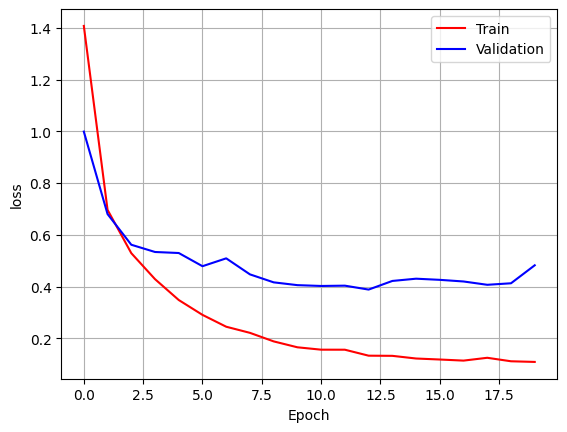

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

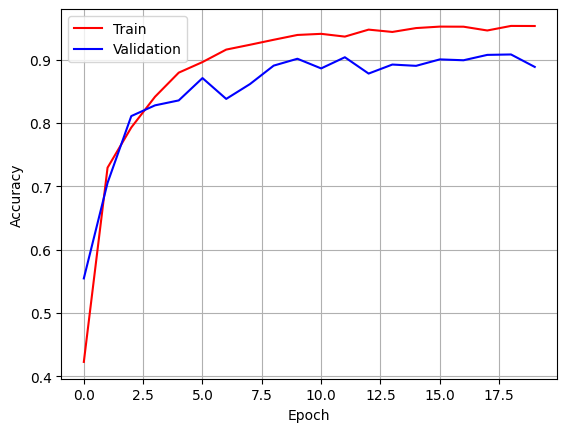

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()